https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping  

In [39]:
data = pd.read_csv('btcusdt_1d_ohlcv_av_1Jan2019_to_24Sep2021_1day_csv_ver.csv')

In [40]:
del data['Unnamed: 0']

In [41]:
# we decide to only take dates in 2021, as we tested previously with other models on the whole dataset and the errors were very high
data = data.loc[data['year'] == 2021]

In [42]:
#here we keep only ohlcv columns
data = data[['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close', 'BTCUSDT_volume']]

#### Train test split

In [44]:
data

,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume
870,28923.63,29600.00,28624.57,29331.69,54182.925011
871,29331.70,33300.00,28946.53,32178.33,129993.873362
872,32176.45,34778.11,31962.99,33000.05,120957.566750
873,32176.45,34778.11,31962.99,33000.05,120957.566750
874,33000.05,33600.00,28130.00,31988.71,140899.885690
...,...,...,...,...,...
1185,47241.75,47347.25,42500.00,43015.62,78003.524443
1186,43016.64,43639.00,39600.00,40734.38,84534.080485
1187,40734.09,44000.55,40565.39,43543.61,58349.055420
1188,43546.37,44978.00,43069.09,44865.26,48699.576550


In [45]:
test_size = 58 # 2 months
#training data from last 2 months only
data_test = data.copy()
data_training = data.copy()
# data_training = data[:-test_size].copy()
# data_test = data[-test_size:].copy()

In [46]:
data_test.shape

(320, 5)

In [47]:
data_training.shape

(320, 5)

#### Normalization

In [49]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)

In [50]:
data_training.shape

(320, 5)

#### X, y split

In [51]:
#create empty list for X, y train
X_train = [] 
y_train = []

In [52]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [53]:
X_train.shape

(260, 60, 5)

In [54]:
y_train.shape

(260,)

#### Initialize the RNN

In [55]:
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

In [56]:
model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')

#### Create early stopping callback so the model trains up to where a loss is not improved

In [57]:
# we set an early stop once the loss is at the minimum
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [58]:
history= model.fit(X_train, y_train, epochs = 1000, batch_size =32, validation_split=0.1, callbacks=[es])

Epoch 1/1000
8/8 [==============================] - 12s 514ms/step - loss: 73.8962 - val_loss: 12.6610
Epoch 2/1000
8/8 [==============================] - 3s 344ms/step - loss: 53.1864 - val_loss: 61.7788
Epoch 3/1000
8/8 [==============================] - 3s 326ms/step - loss: 55.5699 - val_loss: 50.0764
Epoch 4/1000
8/8 [==============================] - 3s 349ms/step - loss: 44.8232 - val_loss: 19.6758
Epoch 5/1000
8/8 [==============================] - 3s 376ms/step - loss: 40.4015 - val_loss: 34.8221
Epoch 6/1000
8/8 [==============================] - 3s 367ms/step - loss: 38.6285 - val_loss: 17.5143
Epoch 7/1000
8/8 [==============================] - 3s 364ms/step - loss: 36.2080 - val_loss: 36.4679
Epoch 8/1000
8/8 [==============================] - 3s 359ms/step - loss: 37.1661 - val_loss: 12.9922
Epoch 9/1000
8/8 [==============================] - 3s 391ms/step - loss: 36.8225 - val_loss: 27.0909
Epoch 10/1000
8/8 [==============================] - 3s 378ms/step - loss: 33.757

#### plotting the training and validation loss

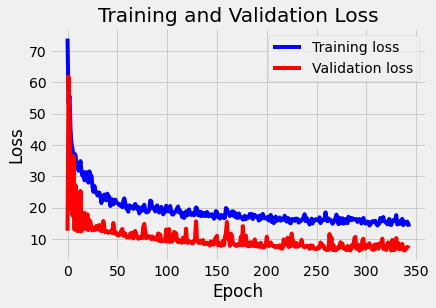

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Test & Make predictions

In [60]:
df

,BTCUSDT_close,BTCUSDT_high,BTCUSDT_low,BTCUSDT_open,BTCUSDT_volume
0,0.264617,0.244025,0.206530,0.189472,0.197213
1,0.199035,0.194503,0.196917,0.179656,0.115064
2,0.189317,0.185446,0.153615,0.183057,0.180639
3,0.192677,0.174448,0.092099,0.066502,0.425084
4,0.077645,0.104918,0.019917,0.092803,0.534849
...,...,...,...,...,...
113,43015.620000,47347.250000,42500.000000,47241.750000,78003.524443
114,40734.380000,43639.000000,39600.000000,43016.640000,84534.080485
115,43543.610000,44000.550000,40565.390000,40734.090000,58349.055420
116,44865.260000,44978.000000,43069.090000,43546.370000,48699.576550


array([[0.        , 0.        , 0.01459339, 0.        , 0.11112994],
       [0.01177644, 0.10495263, 0.02409354, 0.08312981, 0.33562725],
       [0.09387274, 0.14688007, 0.11310091, 0.10712633, 0.30886823],
       ...,
       [0.34083664, 0.40847989, 0.3669339 , 0.41502764, 0.12346701],
       [0.42199589, 0.43620582, 0.44081115, 0.4536235 , 0.09489222],
       [0.46005758, 0.44250298, 0.46502331, 0.45494551, 0.        ]])

In [72]:
data_training

array([[0.        , 0.        , 0.01459339, 0.        , 0.11112994],
       [0.01177644, 0.10495263, 0.02409354, 0.08312981, 0.33562725],
       [0.09387274, 0.14688007, 0.11310091, 0.10712633, 0.30886823],
       ...,
       [0.34083664, 0.40847989, 0.3669339 , 0.41502764, 0.12346701],
       [0.42199589, 0.43620582, 0.44081115, 0.4536235 , 0.09489222],
       [0.46005758, 0.44250298, 0.46502331, 0.45494551, 0.        ]])

In [77]:
pd.DataFrame(data_training)

,0,1,2,3,4
0,0.000000,0.000000,0.014593,0.000000,0.111130
1,0.011776,0.104953,0.024094,0.083130,0.335627
2,0.093873,0.146880,0.113101,0.107126,0.308868
3,0.093873,0.146880,0.113101,0.107126,0.308868
4,0.117641,0.113462,0.000000,0.077592,0.367923
...,...,...,...,...,...
315,0.528640,0.503411,0.424019,0.399609,0.181669
316,0.406708,0.398224,0.338448,0.332990,0.201008
317,0.340837,0.408480,0.366934,0.415028,0.123467
318,0.421996,0.436206,0.440811,0.453623,0.094892


In [78]:
df.columns

Index(['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close',
       'BTCUSDT_volume'],
      dtype='object')

In [79]:
part_60_days = pd.DataFrame(data_training)
part_60_days = part_60_days.tail(60)
part_60_days.columns = ['BTCUSDT_open', 'BTCUSDT_high', 'BTCUSDT_low', 'BTCUSDT_close','BTCUSDT_volume']
df = part_60_days.append(data_test, ignore_index = True)
#df = df.drop(['Date', 'Adj Close'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BTCUSDT_open    380 non-null    float64
 1   BTCUSDT_high    380 non-null    float64
 2   BTCUSDT_low     380 non-null    float64
 3   BTCUSDT_close   380 non-null    float64
 4   BTCUSDT_volume  380 non-null    float64
dtypes: float64(5)
memory usage: 15.0 KB


In [80]:
inputs = scaler.transform(df)

In [ ]:
### Split test set into X, Y

In [84]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i,0])
X_test, y_test = np.array(X_test), np.array(y_test) 


y_pred = model.predict(X_test)

In [85]:
scaler.scale_

array([2.88588795e-05, 2.83655755e-05, 2.95072293e-05, 2.92027844e-05,
       2.96127822e-06])

In [86]:
scale = 1/2.88588795e-05

In [87]:
y_test = y_test*scale 
y_pred = y_pred*scale

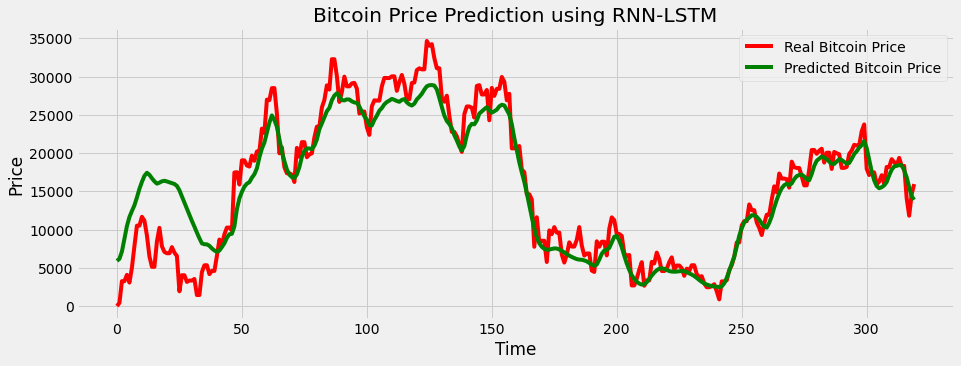

In [88]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()